In [1]:
!git clone https://github.com/kit-hong/CDS521.git

fatal: destination path 'CDS521' already exists and is not an empty directory.


In [2]:
!pip install -q pytorch_lightning

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from pathlib import Path
import cv2

import torch
import torch.nn as nn
import torchvision
import torchmetrics
import pytorch_lightning as pl
import sys

import wandb

In [4]:
from google.colab import userdata

try:
    api_key = userdata.get('WANDB_API_KEY')
    wandb.login(key=api_key)
    anonymous = None
    print("Logged in")
except:
    anonymous = "must"
    print("Log in failed")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: kith777 (kith777-personal) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Logged in


In [5]:
class CFG:

    #utils
    seed          = 42
    train         = True
    inference     = False

    #data config
    LABELS        = ["Unripe", "Early Ripening", "Ripe", "Fully Ripe", "Overripe"]
    batch_size    = 64
    img_size      = 224
    num_classes   = len(LABELS)
    input_channels= 3
    mean          = (0.485, 0.456, 0.406) # imagenet
    std           = (0.229, 0.224, 0.225)

    #training config
    epochs        = 50

    #optimizer config
    lr            = 0.0001
    scheduler     = 'ReduceOnPlateau'
    min_lr        = 1e-6
    optimizer     = 'Adam'
    wd            = 1e-6
    momentum      = 0.9
    num_workers   = 2

    #device config
    device        = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    #model config
    base_model    = 'ConvNext'
    weight        = 'IMAGENET1K_V1'

In [6]:
sys.path.append('/content/CDS521')
outdir = "/content/"

In [7]:
from CDS521.data.create_dataframe import create_dataframe, create_mapping

In [8]:
label2idx, idx2label = create_mapping(CFG.LABELS)

In [9]:
dir = os.getcwd()
data_dir = Path(os.path.join(dir,"CDS521"))
df = create_dataframe(os.path.join(data_dir,'data/processed_data'), CFG.LABELS, label2idx)

Processing Overripe:   0%|          | 0/4142 [00:00<?, ?it/s]
                                                             
Processing Early Ripening:   0%|          | 0/2470 [00:00<?, ?it/s]
                                                                   
Processing Ripe:   0%|          | 0/4427 [00:00<?, ?it/s]
                                                         
Creating DataFrame: 100%|██████████| 5/5 [00:00<00:00, 31.45it/s]


In [10]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [11]:
class FruitData(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        imagepath = row["imagepath"]
        label = row["label"]

        image = cv2.imread(imagepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            image = self.transform(image=image)["image"]

        return image, label

In [12]:
train_df, temp = train_test_split(df, train_size=0.8, random_state=42, stratify=df['label'])
val_df, test_df = train_test_split(temp, test_size=0.5, random_state=42, stratify=temp['label'])

In [13]:
class FruitDataModule(pl.LightningDataModule):
    def __init__(self, train_df, val_df, test_df = None,
                 batch_size = CFG.batch_size, num_worker = CFG.num_workers, pin_memory=True,
                 train_transform = None, eval_transform = None):
        super().__init__()
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.batch_size = batch_size
        self.num_worker = num_worker
        self.pin_memory = pin_memory
        self.train_transform = train_transform
        self.eval_transform = eval_transform

    def setup(self, stage=None):
        self.trainset = FruitData(self.train_df, self.train_transform)
        self.valset = FruitData(self.val_df, self.eval_transform)
        if self.test_df is not None:
            self.testset = FruitData(self.test_df, self.eval_transform)

    def train_dataloader(self):
        return DataLoader(self.trainset, self.batch_size, shuffle=True, num_workers=self.num_worker, pin_memory=self.pin_memory)

    def val_dataloader(self):
        return DataLoader(self.valset, self.batch_size, shuffle=False, num_workers=self.num_worker, pin_memory=self.pin_memory)

    def test_dataloader(self):
        if hasattr(self, 'testset'):
            return DataLoader(self.testset, self.batch_size, shuffle=False, num_workers=self.num_worker, pin_memory=self.pin_memory)


In [14]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.7'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [15]:
def get_mean_std(df):
  means = []
  stds = []

  for _, row in df.iterrows():
      imagepath = row["imagepath"]
      img = cv2.imread(imagepath)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      img = img / 255.0

      means.append(np.mean(img, axis=(0,1)))
      stds.append(np.std(img, axis=(0,1)))

  mean = np.mean(means, axis=0)
  std = np.mean(stds, axis=0)

  return mean, std

In [ ]:
train_transform = A.Compose([
    A.Resize(CFG.img_size, CFG.img_size),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.5),
    A.ElasticTransform(alpha=1.0, sigma=50, p=0.5),
    A.GaussianBlur(blur_limit=(3, 7), p=0.5),
    A.Perspective(scale=(0.0, 0.2), keep_size=True, p=0.5),
    A.Normalize(mean=CFG.mean, std=CFG.std),
    ToTensorV2(),
])

eval_transform = A.Compose([
    A.Resize(CFG.img_size, CFG.img_size),
    A.Normalize(mean=CFG.mean, std=CFG.std),
    ToTensorV2(),
])

<ipython-input-16-69fdff858439>:4: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1.0, sigma=50, alpha_affine=50, p=0.5),


In [17]:
data_module =  FruitDataModule(train_df, val_df, test_df, train_transform = train_transform, eval_transform = eval_transform)

In [18]:
def data_module_sanity_check(data_module, data_module_idx=0):
    data_module.setup()

    trainset = data_module.trainset
    valset = data_module.valset
    print(f"Size of trainset: {len(trainset)}")
    print(f"Size of valset: {len(valset)}")

    train_dataloader = data_module.train_dataloader()
    val_dataloader = data_module.val_dataloader()
    print(f"Size of train loader: {len(train_dataloader)}")
    print(f"Size of val loader: {len(val_dataloader)}")

    for images, labels in train_dataloader:
        print(f"Images batch shape: {images.shape}")
        print(f"Labels batch shape: {len(labels)}")

        first_image = images[data_module_idx]
        first_label = labels[data_module_idx]

        print(f"First image shape: {first_image.shape}")
        print(f"First label idx: {first_label.item()}")
        print(f"First label: {idx2label[first_label.item()]}")

        plt.imshow(first_image.permute(1, 2, 0))
        plt.show()

        break

Size of trainset: 15732
Size of valset: 1966
Size of train loader: 246
Size of val loader: 31


Images batch shape: torch.Size([64, 3, 224, 224])
Labels batch shape: 64
First image shape: torch.Size([3, 224, 224])
First label idx: 4
First label: Overripe


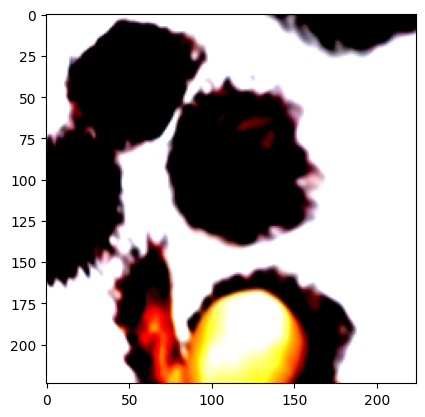

In [19]:
data_module_sanity_check(data_module, 0)

In [20]:
class FruitClassifier(pl.LightningModule):
    def __init__(self, model, loss_fn, lr = CFG.lr, min_lr = CFG.min_lr, num_classes = CFG.num_classes, freeze = False):
        super().__init__()
        self.model = model
        self.loss_fn = loss_fn
        self.lr = lr
        self.min_lr = min_lr
        self.num_classes = num_classes
        self.freeze = freeze

        # modify output layer
        self.model.classifier[-1] = nn.Linear(self.model.classifier[-1].in_features, self.num_classes)

        if self.freeze:
            # freeze layers
            for param in self.model.parameters():
                param.requires_grad = False
            # unfreeze classifier head
            for param in self.model.classifier.parameters():
                param.requires_grad = True

        self.train_accuracy = torchmetrics.Accuracy(task='multiclass',num_classes=self.num_classes)
        self.train_recall = torchmetrics.Recall(task='multiclass',num_classes=self.num_classes, average='weighted')
        self.train_f1 = torchmetrics.F1Score(task='multiclass',num_classes=self.num_classes, average='weighted')
        self.train_precision = torchmetrics.Precision(task='multiclass',num_classes=self.num_classes, average='weighted')
        self.train_auroc = torchmetrics.AUROC(task='multiclass',num_classes=self.num_classes)

        self.val_accuracy = torchmetrics.Accuracy(task='multiclass',num_classes=self.num_classes)
        self.val_recall = torchmetrics.Recall(task='multiclass',num_classes=self.num_classes, average='weighted')
        self.val_f1 = torchmetrics.F1Score(task='multiclass',num_classes=self.num_classes, average='weighted')
        self.val_precision = torchmetrics.Precision(task='multiclass',num_classes=self.num_classes, average='weighted')
        self.val_auroc = torchmetrics.AUROC(task='multiclass',num_classes=self.num_classes)

        self.test_accuracy = torchmetrics.Accuracy(task='multiclass',num_classes=self.num_classes)
        self.test_recall = torchmetrics.Recall(task='multiclass',num_classes=self.num_classes, average='weighted')
        self.test_f1 = torchmetrics.F1Score(task='multiclass',num_classes=self.num_classes, average='weighted')
        self.test_precision = torchmetrics.Precision(task='multiclass',num_classes=self.num_classes, average='weighted')
        self.test_auroc = torchmetrics.AUROC(task='multiclass',num_classes=self.num_classes)

    def forward(self, x):
        logits = self.model(x)
        return logits

    def training_step(self, batch, batch_idx):
        image, label = batch
        logits = self.forward(image)
        train_loss = self.loss_fn(logits, label)
        preds = torch.argmax(logits, dim=1)
        probs = torch.softmax(logits, dim=1)

        step_accuracy = (preds == label).float().mean()

        self.train_accuracy.update(preds, label)
        self.train_recall.update(preds, label)
        self.train_f1.update(preds, label)
        self.train_precision.update(preds, label)
        self.train_auroc.update(probs, label)

        self.log("train_loss", train_loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log("train_accuracy_step", step_accuracy, on_step=True, prog_bar=True)
        self.log("train_recall_step", self.train_recall, on_step=True, prog_bar=True)
        self.log("train_precision_step", self.train_precision, on_step=True, prog_bar=True)
        self.log("train_f1_step", self.train_f1, on_step=True, prog_bar=True)
        self.log("train_auroc_step", self.train_auroc, on_step=True, prog_bar=True)

        return train_loss

    def on_train_epoch_end(self):
        self.log("train_accuracy", self.train_accuracy.compute(), on_epoch=True, prog_bar=True)
        self.log("train_recall", self.train_recall.compute(), on_epoch=True, prog_bar=True)
        self.log("train_precision", self.train_precision.compute(), on_epoch=True, prog_bar=True)
        self.log("train_f1", self.train_f1.compute(), on_epoch=True, prog_bar=True)
        self.log("train_auroc", self.train_auroc.compute(), on_epoch=True, prog_bar=True)

        self.train_accuracy.reset()
        self.train_recall.reset()
        self.train_precision.reset()
        self.train_f1.reset()
        self.train_auroc.reset()

    def validation_step(self, batch, batch_idx):
        image, label = batch
        logits = self.forward(image)
        val_loss = self.loss_fn(logits, label)
        preds = torch.argmax(logits, dim=1)
        probs = torch.softmax(logits, dim=1)

        self.val_accuracy.update(preds, label)
        self.val_recall.update(preds, label)
        self.val_f1.update(preds, label)
        self.val_precision.update(preds, label)
        self.val_auroc.update(probs, label)

        self.log("val_loss", val_loss, on_step=True, on_epoch=True, prog_bar=True)
        return val_loss

    def on_validation_epoch_end(self):
        self.log("val_accuracy", self.val_accuracy.compute(), on_epoch=True, prog_bar=True)
        self.log("val_recall", self.val_recall.compute(), on_epoch=True, prog_bar=True)
        self.log("val_precision", self.val_precision.compute(), on_epoch=True, prog_bar=True)
        self.log("val_f1", self.val_f1.compute(), on_epoch=True, prog_bar=True)
        self.log("val_auroc", self.val_auroc.compute(), on_epoch=True, prog_bar=True)

        self.val_accuracy.reset()
        self.val_recall.reset()
        self.val_precision.reset()
        self.val_f1.reset()
        self.val_auroc.reset()

    def test_step(self, batch, idx):
        image, label = batch
        logits = self.forward(image)
        test_loss = self.loss_fn(logits, label)
        preds = torch.argmax(logits, dim=1)
        probs = torch.softmax(logits, dim=1)

        self.test_accuracy.update(preds, label)
        self.test_recall.update(preds, label)
        self.test_precision.update(preds, label)
        self.test_f1.update(preds, label)
        self.test_auroc.update(probs, label)

        self.log("test_loss", test_loss, on_step=True, on_epoch=True, prog_bar=True)
        return test_loss

    def on_test_epoch_end(self):
        self.log("test_accuracy", self.test_accuracy.compute(), on_epoch=True, prog_bar=True)
        self.log("test_recall", self.test_recall.compute(), on_epoch=True, prog_bar=True)
        self.log("test_precision", self.test_precision.compute(), on_epoch=True, prog_bar=True)
        self.log("test_f1", self.test_f1.compute(), on_epoch=True, prog_bar=True)
        self.log("test_auroc", self.test_auroc.compute(), on_epoch=True, prog_bar=True)

        self.test_accuracy.reset()
        self.test_recall.reset()
        self.test_precision.reset()
        self.test_f1.reset()
        self.test_auroc.reset()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, threshold= 0.005, min_lr= self.min_lr)
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_loss',
                'interval': 'epoch',
                'frequency': 1
            }
        }


In [21]:
base_model = torchvision.models.convnext_base(weights=CFG.weight)
loss_fn = nn.CrossEntropyLoss()

In [22]:
model = FruitClassifier(base_model, loss_fn, lr=CFG.lr, num_classes = CFG.num_classes, freeze = True)

In [23]:
from pytorch_lightning.loggers.wandb import WandbLogger

wandb_logger = WandbLogger(
    project='Fruit Classification',
    name='ConvNeXt',
    log_model=True
)

In [ ]:
callbacks = [
    pl.callbacks.ModelCheckpoint(
        dirpath=outdir,
        filename="best-model-{epoch:02d}-{val_loss:.2f}",
        monitor="val_loss",
        mode="min",
        save_top_k=1,
        save_last=True,
    ),
    pl.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        mode="min",
        verbose=False,
        min_delta = 0.005,
    ),
    pl.callbacks.LearningRateMonitor(logging_interval="epoch")
]

In [25]:
pl.seed_everything(CFG.seed)

INFO:lightning_fabric.utilities.seed:Seed set to 42


42

In [26]:
trainer = pl.Trainer(
    callbacks=callbacks,
    max_epochs= CFG.epochs,
    devices='auto',
    enable_progress_bar=True,
    precision="16-mixed",
    val_check_interval=1.0,
    logger=wandb_logger,
    deterministic=True,
)

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..


In [27]:
trainer.fit(model, datamodule=data_module)

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | model           | ConvNeXt            | 87.6 M | train
1  | loss_fn         | CrossEntropyLoss    | 0      | train
2  | train_accuracy  | MulticlassAccuracy  | 0      | train
3  | train_recall    | MulticlassRecall    | 0      | train
4  | train_f1        | MulticlassF1Score   | 0      | train
5  | train_precision | MulticlassPrecision | 0      | train
6  | train_auroc     | MulticlassAUROC     | 0      | train
7  | val_accuracy    | MulticlassAccuracy  | 0      | train
8  | val_recall      | MulticlassRecall    | 0      | train
9  | val_f1          | MulticlassF1Score   | 0      | t

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.789


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.187 >= min_delta = 0.0. New best score: 0.601


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.090 >= min_delta = 0.0. New best score: 0.511


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.052 >= min_delta = 0.0. New best score: 0.459


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.033 >= min_delta = 0.0. New best score: 0.426


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.034 >= min_delta = 0.0. New best score: 0.392


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.021 >= min_delta = 0.0. New best score: 0.371


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.019 >= min_delta = 0.0. New best score: 0.352


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.336


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.013 >= min_delta = 0.0. New best score: 0.323


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.012 >= min_delta = 0.0. New best score: 0.311


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.304


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.011 >= min_delta = 0.0. New best score: 0.292


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 0.284


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.276


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.268


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.262


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.255


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.252


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.245


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.241


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.240


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.234


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.232


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.0. New best score: 0.225


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.221


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.219


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.212


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.212


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.210


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.206


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.205


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.205


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.201


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.199


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.194


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.189


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.189


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.187


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.186


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.183


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.181


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.178


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.178


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


In [28]:
trainer.test(model, datamodule=data_module, ckpt_path='best')

INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/best-model-epoch=48-val_loss=0.18.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/best-model-epoch=48-val_loss=0.18.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9517030715942383     │
│        test_auroc         │    0.9967867732048035     │
│          test_f1          │    0.9514785408973694     │
│      test_loss_epoch      │    0.17026683688163757    │
│      test_precision       │     0.951453685760498     │
│        test_recall        │    0.9517031311988831     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss_epoch': 0.17026683688163757,
  'test_accuracy': 0.9517030715942383,
  'test_recall': 0.9517031311988831,
  'test_precision': 0.951453685760498,
  'test_f1': 0.9514785408973694,
  'test_auroc': 0.9967867732048035}]

In [29]:
wandb.finish()

In [32]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 104.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=bfbc4d434c376a1a4282151e5db78229e60834b483fabd413e651b789bbda0ca
  Stored in directory: /root/.cache/pip/wheels/bc/52/78/893c3b94279ef238f43a9e89608af648de401b96415bebbd1f
Successfully built grad-cam


In [33]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

In [67]:
def find_target_layers(model):
    """Find suitable target layers for Grad-CAM"""
    target_layers = []

    # Look for common patterns
    patterns_to_try = [
        lambda m: [layer for layer in m.modules() if isinstance(layer, torch.nn.Conv2d)][-1:],  # Last conv layer
        lambda m: [m.features[-1]] if hasattr(m, 'features') else [],  # Features layer
        lambda m: [m.backbone.layer4[-1]] if hasattr(m, 'backbone') and hasattr(m.backbone, 'layer4') else [],  # ResNet-like
        lambda m: [m.encoder.layers[-1]] if hasattr(m, 'encoder') and hasattr(m.encoder, 'layers') else [],  # Transformer-like
    ]

    for pattern in patterns_to_try:
        try:
            layers = pattern(model)
            if layers:
                return layers
        except:
            continue

    return []

In [69]:
def grad_cam(model, image, transform=eval_transform, target_class=None, layer_name=None):
    transformed = transform(image=image)
    input_tensor = transformed["image"].unsqueeze(0).to(CFG.device)
    model = model.to(CFG.device).eval()

    input_tensor.requires_grad_(True)

    # Predict target class if not provided
    if target_class is None:
        with torch.no_grad():
            output = model(input_tensor)
            target_class = torch.argmax(output).item()

    targets = [ClassifierOutputTarget(target_class)]
    rgb_image = image.astype(np.float32) / 255.0

    # If specific layer name provided, use it
    if layer_name:
        target_layer = None
        for name, module in model.named_modules():
            if name == layer_name:
                target_layer = module
                break
        if target_layer is None:
            raise ValueError(f"Layer '{layer_name}' not found in model")
        target_layers = [target_layer]
    else:
        # Auto-detect suitable layer
        target_layers = find_target_layers(model)

    if not target_layers:
        raise ValueError("No suitable target layer found")

    print(f"Using target layer: {target_layers[0]}")

    cam = GradCAM(model=model, target_layers=target_layers)
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]
    visualization = show_cam_on_image(rgb_image, grayscale_cam, use_rgb=True)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Original")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(grayscale_cam, cmap='hot')
    plt.title("Heatmap")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(visualization)
    plt.title(f"Overlay (Class: {target_class})")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return grayscale_cam

In [35]:
image_path = test_df.iloc[0]["imagepath"]

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

Using target layer: Conv2d(1024, 1024, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=1024)


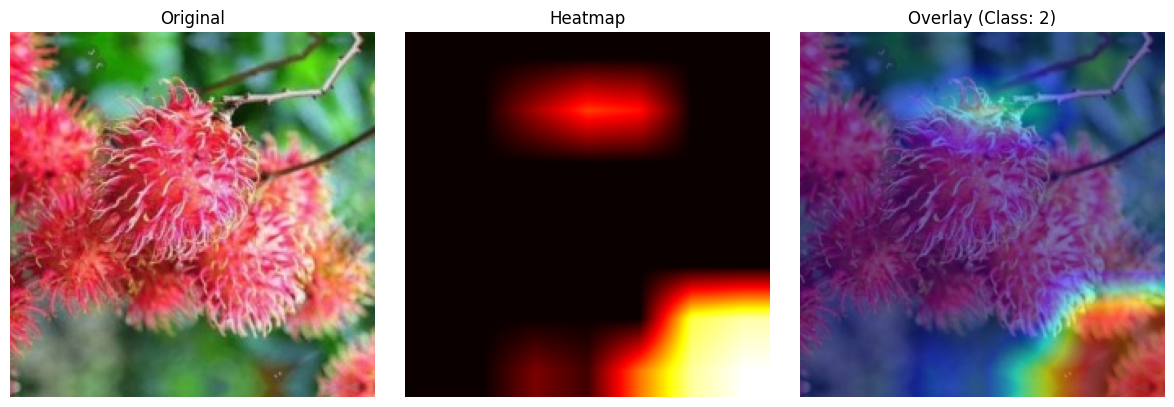

In [70]:
grayscale_cam = grad_cam(model=model.model, image=image)

In [83]:
def visualize_gradcam_stages(model, image, transform=eval_transform, target_class=None, figsize=(16, 12)):
    transformed = transform(image=image)
    input_tensor = transformed["image"].unsqueeze(0).to(CFG.device)
    model = model.to(CFG.device).eval()

    input_tensor.requires_grad_(True)

    # Predict target class if not provided
    if target_class is None:
        with torch.no_grad():
            output = model(input_tensor)
            target_class = torch.argmax(output).item()

    targets = [ClassifierOutputTarget(target_class)]
    rgb_image = image.astype(np.float32) / 255.0

    # Key layers representing each stage
    stage_layers = [
        ("features.0.0", "Stage 0: Initial Conv\n(3→96 channels)"),
        ("features.1.1.block.0", "Stage 1: Early Features\n(96 channels)"),
        ("features.3.1.block.0", "Stage 2: Mid-level Features\n(192 channels)"),
        ("features.5.4.block.0", "Stage 3: High-level Features\n(384 channels)"),
        ("features.7.1.block.0", "Stage 4: Semantic Features\n(768 channels)"),
    ]

    fig, axes = plt.subplots(2, 3, figsize=figsize)
    axes = axes.flatten()

    # Plot original image
    axes[0].imshow(image)
    axes[0].set_title("Original Image", fontsize=12, fontweight='bold')
    axes[0].axis('off')

    print(f"Analyzing ConvNeXt stages for class {target_class}")
    print("=" * 60)

    for idx, (layer_name, layer_title) in enumerate(stage_layers):
        try:
            target_layer = model
            for part in layer_name.split('.'):
                target_layer = getattr(target_layer, part)

            cam = GradCAM(model=model, target_layers=[target_layer])
            grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]

            visualization = show_cam_on_image(rgb_image, grayscale_cam, use_rgb=True)

            ax = axes[idx + 1]
            ax.imshow(visualization)
            ax.set_title(f"{layer_title}", fontsize=10)
            ax.axis('off')

            print(f"{layer_title.split(':')[1].strip()}")

        except Exception as e:
            print(f"Failed to process {layer_name}: {e}")
            ax = axes[idx + 1]
            ax.text(0.5, 0.5, f"Error\n{layer_name}", ha='center', va='center', transform=ax.transAxes)
            ax.axis('off')

    plt.tight_layout()
    plt.suptitle(f"ConvNeXt Stage-wise Feature Learning Analysis (Class: {target_class})",
                 fontsize=14, y=0.95)
    plt.show()

Analyzing ConvNeXt stages for class 2
Initial Conv
(3→96 channels)
Early Features
(96 channels)
Mid-level Features
(192 channels)
High-level Features
(384 channels)
Semantic Features
(768 channels)


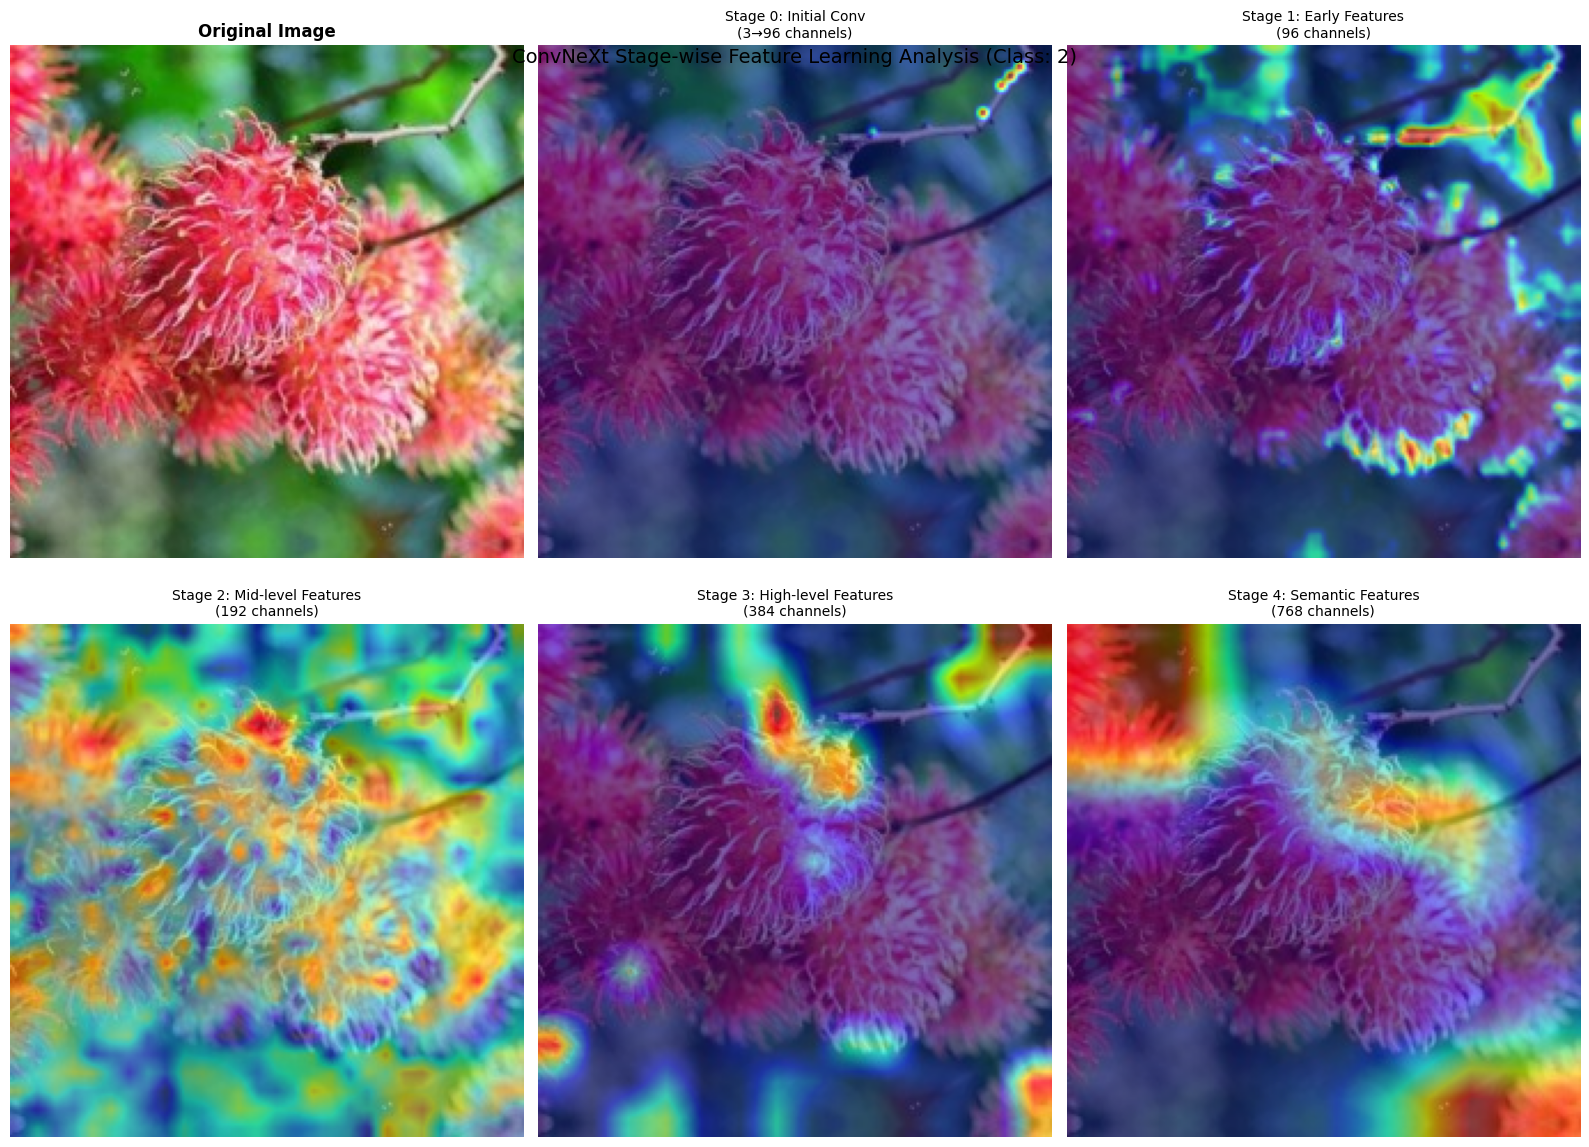

In [84]:
visualize_gradcam_stages(model=model.model, image=image)